# Assignment 4 - DDPG

During labs you have learnt about DQN - an algorithm for solving discrete action environments.
In this task you will implement DDPG which can be thought of as DQN variation for environments with continuous action space.

You should implement missing parts of the training loop which are annotated with the following comment:
```
#########################
### TODO - YOUR CODE ####
#########################
```



Here is the pesudocode from the original work: 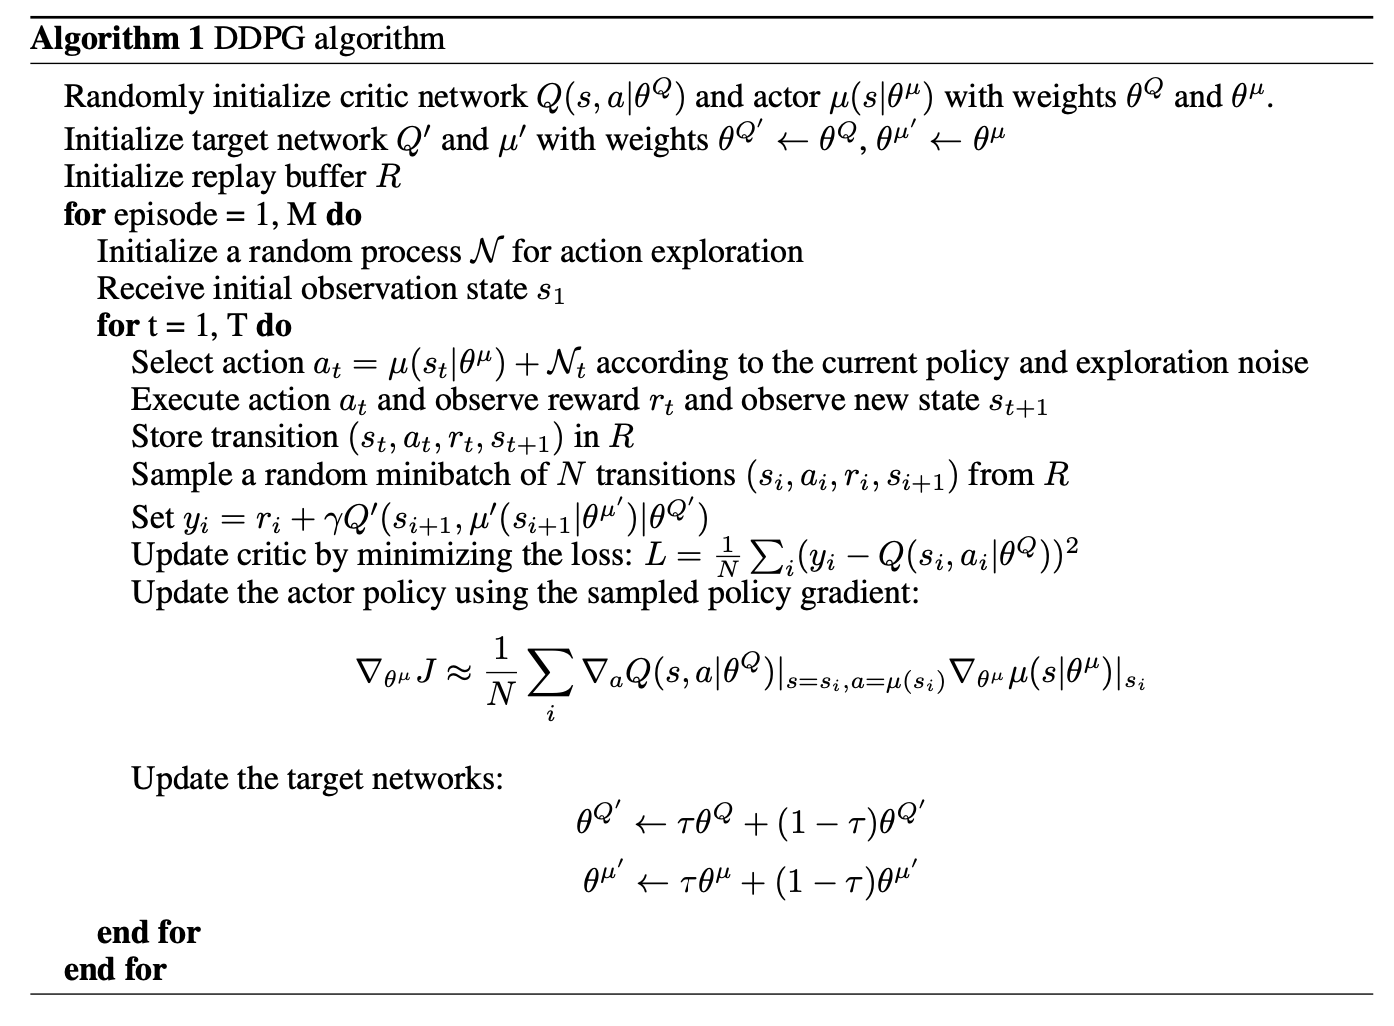

### Resources

- [openai/gym](https://gym.openai.com/docs/)
- [getting-started-with-openai-gym](https://blog.paperspace.com/getting-started-with-openai-gym/)
- [Continuous control with deep reinforcement learning (DDPG)](https://arxiv.org/abs/1509.02971)
- [Deterministic Policy Gradient Algorithms](http://proceedings.mlr.press/v32/silver14.pdf)

You can read about actor policy update step and how to implement it here:
- https://www.quora.com/Why-is-the-loss-for-DDPG-Actor-the-product-of-gradients-of-Q-values-actions
- https://stackoverflow.com/questions/51496159/ddpg-deep-deterministic-policy-gradients-how-is-the-actor-updated


## Requirements

1. Experiments reproducability:

    You should ensure that you can re-run your experiments and obtain the same results. To do so implement `set_seed` function that handles necessary logic. Pick one of the experiments (short one) and re-run it with logging of the losses/mean_rewards to show that results are reproduced.

2. Implement Polyak average for updating network's parameters:

    During labs about DQN you have seen that target's network parameters can be updated every K steps by overwritting old parameters. There are other, more robust, methods to do so. One of the most popular is polyak average (weighted moving average). Your tasks will be to implement it as well.

3. Implement DDPG algorithm:

    Read paper carefully, and don't forget about exploration.

4. Environments:

    Solve the environmets listed below and reach the corresponding benchmark score.

5. Analysis of different hyperparameters.

    Pick one of the environments and repeat the training 5 times with a different subset of hyperparameters such that the results differ. Present comparison of used parameters' configurations, training summary, plots, and your conclusions.

    Tip: RL algorithms are especially parameter sensitive. It's a good occasion to ponder how to organize your work such that you can easily track and compare different runs and configurations. Organize your experiments or use a utility such as [tensorboard](https://pytorch.org/docs/stable/tensorboard.html), [neptune](neptune.ai), [wandb](wandb.ai) or [clearml](https://clear.ml/).


### Evaluation & Grading

Total points: 12
- Seed initalization & experiment reproducibility [0.5]
- Polyak average [0.5]
- Gaussian noise [0.5]
- DDPG [5.5]
- Solving environments (benchmark) [3.0]
- Analysis of different hyperparameters [2.0]

#### Benchmark
For each of the following environments you should train one agent and obtain at least the following mean score in our benchmark:
```
"Pendulum-v1" : -160,
"LunarLanderContinuous-v2": 130,
"MountainCarContinuous-v0": 80
```



Tips:
- Study environment's action space and ensure that your cover the whole range. Perhaps Tanh activation could be useful?
- Adding noise to the action can take you out of the environment's action space. Ensure that the final action is valid before calling `env.step(action)`.
- RL agents tend to forget previously learnt behaviors, especially if algorithm is not very stable. Therefore, it's a good practice to evaluate and save checkpoints (weights of the model) every K-th steps. You can later load the best set of parameters.
- Here are a few statistics that are usefull to track your training progress:
```
logs = {
    "episodes_rews": [],
    "episodes_lens": [],
    "critic_losses": [], 
    "actor_losses": []
}
```
For example, it's useful to log mean episode reward for last 50 episodes.

# Environment setup, helper functions & classes

Remember to restart your runtime after installing the packages.

In [ ]:
!pip3 install 'gym==0.21.0' > /dev/null 2>&1
!pip3 install box2d-py==2.3.8 > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip3 install ez_setup > /dev/null 2>&1
!pip3 install gym[atari] > /dev/null 2>&1
!pip3 install gym[Box_2D] > /dev/null 2>&1
!pip3 install pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* > /dev/null 2>&1

In [ ]:
import copy
import random
import numpy as np
import torch
import torch.nn as nn
from typing import List, Optional, Callable, Tuple
from collections import namedtuple
import imageio
from pathlib import Path
import gym
from pyvirtualdisplay import Display

/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


### Benchmark

Don't modify Benchmark's cell. Your solution should pass the proposed thresholds.

In [ ]:
def as_tensor(data: np.ndarray, dtype=torch.float32, batch: bool = False) -> torch.Tensor:
    tensor = torch.tensor(data, dtype=dtype, device=DEVICE)
    if batch and len(tensor.shape) == 1:
        tensor = tensor.unsqueeze(dim=1)
    return tensor

class Benchmark:
    def __init__(self):
        """ Don't modify. Your agent should pass those benchmarks. """
        self.env_to_mean_score = {
            "Pendulum-v1" : -160,
            "LunarLanderContinuous-v2": 130,
            "MountainCarContinuous-v0": 80
        }
        self.n_episodes = 100
        self.seed = 42
    
    def run(self, env_id: str, policy) -> None:
        env = gym.make(env_id)
        stats = self._eval(env, policy, self.n_episodes, self.seed)
        score = np.mean(stats["episodes_rews"])
        result = "Success" if score > self.env_to_mean_score[env_id] else "Failure"
        print(f"{result} on {env_id} with mean score: {score}")
        assert len(stats["episodes_rews"]) == self.n_episodes

    def _eval(self, env, policy, n_episodes: int = 100, seed: Optional[int] = None):
        print("\nStarting Benchmark:")
        print("seed:", seed)
        print("n_episodes:", n_episodes)
        if seed: # Be careful, this will reset your rng!
            set_seeds(env, seed)

        stats = {
            "episodes_rews": [],
            "episodes_lens": [],
        }
        
        for episode in range(n_episodes):
            done = False
            obs = env.reset()
            ep_rew, ep_len = 0, 0

            while not done:
                with torch.no_grad():
                    action = policy(as_tensor(obs).reshape(1,-1)).numpy() # No exploration noise during evalution!
                    action = action[0]
                obs, reward, done, _ = env.step(action)
                ep_rew += reward
                ep_len += 1
            
            stats["episodes_lens"].append(ep_len)
            stats["episodes_rews"].append(ep_rew)

        print("Rewards:", stats["episodes_rews"])
        print("Lengths:", stats["episodes_lens"])
        print("Mean episode reward:", np.mean(stats["episodes_rews"]))
        print("Mean episode length:", np.mean(stats["episodes_lens"]))

        return stats

### Utilities

A few helper functions to help you get started.

In [ ]:
def eval(env, policy, n_episodes: int = 100, seed: Optional[int] = None):
    """ Helper method to evaluate agent """
    if seed: # Be careful, this will reset your rng!
        set_seeds(env, seed)

    stats = {
        "episodes_rews": [],
        "episodes_lens": [],
    }
    
    for episode in range(n_episodes):
        done = False
        obs = env.reset()
        ep_rew, ep_len = 0, 0

        while not done:
            with torch.no_grad():
                obs = as_tensor(obs).reshape(1,-1)
                action = policy(obs).numpy() # No exploration noise during evalution
            obs, reward, done, _ = env.step(action)
            ep_rew += reward
            ep_len += 1
        
        stats["episodes_lens"].append(ep_len)
        stats["episodes_rews"].append(ep_rew)

    print("Rewards:", stats["episodes_rews"])
    print("Lengths:", stats["episodes_lens"])
    print("Mean episode reward:", np.mean(stats["episodes_rews"]))
    print("Mean episode length:", np.mean(stats["episodes_lens"]))

    return stats

In [ ]:
def make_gif(env_id, actor = None, n_episodes: int = 1, gif_name: str = "agent.gif", dir: str = "./gifs"):
    """ 
    Create a gif of an agent interacting with an environment.
    Note: It does not always work in Google colab, and crashes from time to time.
    """
    display = Display(visible=0, size=(1400, 900))
    display.start()

    Path(dir).mkdir(parents=True, exist_ok=True)
    filename = Path(dir).joinpath(gif_name)

    images = []
    env = gym.make(env_id)
    for _ in range(n_episodes):
        obs, done = env.reset(), False
        images.append(env.render("rgb_array"))
        while not done:
            if actor:
                with torch.no_grad():
                    action = actor(as_tensor(obs).reshape(1,-1)).numpy()
            else:
                action = env.action_space.sample() 
            obs, reward, done, _ = env.step(action) 
            images.append(env.render("rgb_array"))

    imageio.mimsave(filename, images, fps=29)

In [ ]:
def try_gpu(i: int = 0) -> None:
    """ Return gpu(i) if exists, otherwise return cpu() """
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In gym environments Box(n,) corresponds to the n-dimensional continuous space. The observation space has upper and lower bounds that describe the range of values it can take.

In [ ]:
def describe_env(env_id: str) -> None:
    print(env_id)
    env = gym.make(env_id)
    spec = gym.spec(env_id)
    print(f"Environment: {env_id}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Observation Space High: {env.observation_space.high}")
    print(f"Observation Space Low: {env.observation_space.low}")
    print(f"Action Space: {env.action_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")

continuous_envs = ["Pendulum-v1", "LunarLanderContinuous-v2", "MountainCarContinuous-v0"]

print(80*"#" + "\n")
for i, env in enumerate(continuous_envs):
    describe_env(env)
    print("\n" + 80*"#" + "\n")

################################################################################

Pendulum-v1
Environment: Pendulum-v1
Observation Space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Observation Space High: [1. 1. 8.]
Observation Space Low: [-1. -1. -8.]
Action Space: Box([-2.], [2.], (1,), float32)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None

################################################################################

LunarLanderContinuous-v2
Environment: LunarLanderContinuous-v2
Observation Space: Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Observation Space High: [inf inf inf inf inf inf inf inf]
Observation Space Low: [-inf -inf -inf -inf -inf -inf -inf -inf]
Action Space: Box([-1. -1.], [1. 1.], (2,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 200

###################################################################

In [ ]:
# is_terminal is a mask indicating whether the state is terminal or not
# it is usefull when using target_net for predicting qvalues.
Transition = namedtuple("Transition",
                        ("state", "action", "next_state", "reward", "is_terminal"))

class ReplayBuffer(object):
    def __init__(self, size: int):
        """ Create new replay buffer.

        Args:
            size: capacity of the buffer
        """
        self._storage = []
        self._capacity = size
        self._next_idx = 0

    def add(self, transition: Transition) -> None:
        if len(self._storage) < self._capacity:
            self._storage.append(None)
        self._storage[self._next_idx] = transition
        self._next_idx = (self._next_idx + 1) % self._capacity

    def sample(self, batch_size: int) -> List[Transition]:
        """ Sample batch of experience from memory.

        Args:
            batch_size: size of the batch

        Returns:
            batch of transitions
        """
        batch = random.sample(self._storage, batch_size)
        return batch

    def __len__(self) -> int:
        return len(self._storage)

# Solution

## Code

In [ ]:
class MLP(nn.Module):
    """ Simple MLP net.

    Each of the layers, despite the last one, is followed by `activation`, and the last one
    is optionally followed by `output_activation`.
    """
    def __init__(self, layers_sizes: List[int], activation: nn.Module = nn.ReLU, output_activation: Optional[nn.Module] = None) -> None:
        super(MLP, self).__init__()
        self.layers_sizes = layers_sizes
        modules = []
        for in_features, out_features in zip(layers_sizes, layers_sizes[1:-1]):
            modules.extend([
                nn.Linear(in_features, out_features),
                nn.BatchNorm1d(out_features),
                activation()
            ])
        modules.extend([nn.Linear(layers_sizes[-2], layers_sizes[-1])])
        if output_activation:
            modules.extend([output_activation()])
        self.layers = nn.Sequential(*modules)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        out = self.layers(obs)
        return out

    def save(self, path: str) -> None:
        torch.save(self.state_dict(), path)

    def load(self, path: str) -> None:
        self.load_state_dict(torch.load(path))

In [ ]:
class Actor(MLP):
    def __init__(self, action_scale: float, seed=42, *args, **kwargs):
        """
        Sometimes environment's have action range bigger than (-1, 1). 
        Thus we want to scale it appropriately to cover the whole range. Here we assume that the
        final layer is Tanh so scaling the output is enough.
        """
        torch.manual_seed(seed)
        super(Actor, self).__init__(*args, **kwargs)
        self.action_scale = action_scale
       

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return self.action_scale * super().forward(obs)

In [ ]:
class Critic(MLP):
    def __init__(self, action_dim, layers_sizes: List[int], activation: nn.Module = nn.ReLU, seed=42, *args, **kwargs):
        torch.manual_seed(seed)
        super(Critic, self).__init__(layers_sizes=layers_sizes, *args, **kwargs)
        # self.action_scale = action_scale
        self.final_size = layers_sizes[-1]
        self.action_dim = action_dim
        self.fca = nn.Linear(self.action_dim ,self.final_size)
        self.relu = nn.ReLU()
        #self.fcq = nn.Linear(self.final_size + action_dim, 1)
        self.fcq = nn.Linear(self.final_size, 1)
    # def forward(self, obs, action):
    #     state_value = super().forward(obs)
    #     action_value = self.relu(self.fca(action))
    #     Q_value = self.relu(torch.cat([action_value, state_value], 1))
    #     Q_value = self.fcq(Q_value)

    #     return Q_value
    def forward(self, obs, action):
          x = torch.cat([obs, action], 1)
          x = super().forward(x)
          x = self.fcq(x)
          return x

In [ ]:
def set_seeds(env: gym.Env, seed=42) -> None:
    """
    Set random seeds for reproduceability.
    See: https://pytorch.org/docs/stable/notes/randomness.html
         https://harald.co/2019/07/30/reproducibility-issues-using-openai-gym/
    """
    torch.manual_seed(seed)
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.action_space.seed(seed)

In [ ]:
def polyak_average(net1: nn.Module, net2: nn.Module, tau: float) -> None:
    """ 
    Update parameters of net1 with parameters of net2 as a weighted sum of both.
    """
    for param1, param2 in zip(net1.parameters(), net2.parameters()):
                param1.data.copy_(
                    param2.data * (1.0 - tau) + param1.data * tau
                )
    # net1 = tau*net1.parameters().data + (1-tau) * net2.weights


In [ ]:
def test_polyak_average():
    net1, net2 = MLP([2, 2]), MLP([2, 2])
    with torch.no_grad():
        net1.layers[0].weight.fill_(1)
        net1.layers[0].bias.fill_(1)
        net2.layers[0].weight.fill_(-1) 
        net2.layers[0].bias.fill_(0.5)
    print(list(net1.named_parameters())) 
    print(list(net2.named_parameters())) 
    polyak_average(net1, net2, tau=0.9)
    print(list(net1.named_parameters())) 

    expected_weight = torch.tensor([[0.8, 0.8], [0.8, 0.8]])
    expected_bias = torch.tensor([0.95, 0.95])
    assert torch.allclose(net1.layers[0].weight.data, expected_weight)
    assert torch.allclose(net1.layers[0].bias.data, expected_bias)

test_polyak_average()

[('layers.0.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([1., 1.], requires_grad=True))]
[('layers.0.weight', Parameter containing:
tensor([[-1., -1.],
        [-1., -1.]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True))]
[('layers.0.weight', Parameter containing:
tensor([[0.8000, 0.8000],
        [0.8000, 0.8000]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([0.9500, 0.9500], requires_grad=True))]


In [ ]:
def gaussian_action_noise(action_dim: np.ndarray, mean: float, std: float) -> Callable[[], float]:
    """
    Returns function that samples noise of shape action_dim from the normal distribution N(mean, std) 
    """
    def noise():
        return np.random.normal(mean, std, action_dim)
    return noise

# ClearML

In [ ]:
!pip install clearml

     |████████████████████████████████| 1.1 MB 7.0 MB/s 


In [ ]:
from clearml import Task

In [ ]:

web_server = 'https://app.community.clear.ml'
api_server = 'https://api.community.clear.ml'
files_server = 'https://files.community.clear.ml'
access_key = ' '#@param {type:"string"}
secret_key = ' '#@param {type:"string"}

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

# DDPG

In [ ]:
from math import inf
from copy import copy, deepcopy 

def new_ddpg(env: gym.Env, actor, critic, actor_optim, critic_optim, 
         action_noise: Callable[[], float], total_steps: int, 
         buffer_size: int, batch_size: int, 
         gamma: float, polyak: float, initial_exploration_steps: int,
         episodes: int, reward_threshold:int, env_name: str, task, logger):
    # Initialize necessary objects for the training
    set_seeds(env)
    MSE = nn.MSELoss()
    target_actor = deepcopy(actor)
    target_critic = deepcopy(critic)
    replay_buffer = ReplayBuffer(buffer_size)
    action_min, action_max = env.action_space.low, env.action_space.high
    c_losses = []
    a_losses = []
    rewards = []
    average_reward = 0
    best_reward = -inf
    PATH = '/content/drive/My Drive/DDPG_NETS/'

    def get_action(obs):
        """ 
        Calculate next action with exploration via Gaussian noise
        Remember to:
        1. Not calculate gradients for this forward pass.
        2. Include exploration noise.
        3. Clip action to fit within the environment's action space after adding the noise. 
        """
        with torch.no_grad():
            actor.eval()
            obs = obs.reshape(1,-1)
            action = actor(obs)
            action += action_noise()
            action = np.clip(action, action_min, action_max)
        actor.train()
        return action

    def calculate_target(batch):
        with torch.no_grad():
            target_expectation = target_critic(batch.next_state, target_actor(batch.next_state))
            expected_target_q = batch.reward + (1 - batch.is_terminal) * gamma * target_expectation
        return expected_target_q 

    def calculate_critic_loss(batch):
        """
        Calculate critic's loss for a given batch.
        """
        target = calculate_target(batch)
        q = critic(batch.state, batch.action)
        q_loss = MSE(q, target)

        return q_loss


    def calculate_actor_loss(batch):
        """
        Calculate actor's loss for a given batch.
        Remember that we want to maximize qvalue returned by critic, which represents the expected 
        future reward. Therefore, we want to do gradient ascent. However, optimizer always performs 
        gradient descent.
        """
        critic.eval()
        actor_loss = - critic(batch.state, actor(batch.state)).mean()
        # actor_loss = actor_loss.mean()
        return actor_loss


    def update_step(i_step):
        # Sample minibatch
        transitions = replay_buffer.sample(batch_size)
        # Convert from list of tuples to tuple of lists
        batch = Transition(*zip(*transitions))
        batch = Transition(as_tensor(batch.state, batch=True), 
                           as_tensor(batch.action, batch=True),
                           as_tensor(batch.next_state, batch=True),
                           as_tensor(batch.reward, batch=True),
                           as_tensor(batch.is_terminal, batch=True))
        # Critic step
        critic_optim.zero_grad()
        critic_loss = calculate_critic_loss(batch)
        critic_loss.backward()
        critic_optim.step()
        # Actor step
        actor_optim.zero_grad()
        actor_loss = calculate_actor_loss(batch)
        actor_loss.backward()
        actor_optim.step()
        critic.train()
        # Update target networks ~ 2 lines
        polyak_average(target_actor, actor, polyak)
        polyak_average(target_critic, critic, polyak)
        print("Loss actor:", actor_loss.item(), "loss critic:", critic_loss.item())
        logger.report_scalar(title='Actor loss', series='Train', iteration=i_step, value=actor_loss)
        logger.report_scalar(title='Critic loss', series='Train', iteration=i_step, value=critic_loss)
        return reward

    def save_models(rew):
        torch.save(critic, "Critic_net_" + str(rew))
        torch.save(actor, "Actor_net_" + str(rew))
        torch.save(target_actor, "Actor_target_net_" + str(rew))
        torch.save(target_critic, "Critic_target_net_" + str(rew) )


    step = 0
    avrg_reward = 0
    for episode in range(episodes):
        #set_seeds(env)
        ep_reward = 0
        obs = env.reset()
        terminal = False
        for es in range(total_steps):
        # while not terminal:
            with torch.no_grad():
                # exploration steps or get action
                if step < initial_exploration_steps:
                    action = env.action_space.sample()
                else:
                    action = get_action(as_tensor(obs))

                # get new transition and add to buffer
                if type(action) is not np.ndarray: 
                    action = action.numpy()
                    action = np.squeeze(action, axis=0)
                state_next, reward, terminal, info = env.step(action)
                transition = Transition(obs, action, state_next, reward, terminal)
                replay_buffer.add(transition)
                obs = state_next
            if terminal:
              break
            # if buffer is full enough start making update steps
            if len(replay_buffer) > batch_size:
                if type(action) is not np.ndarray: action = action.numpy()
                update_step(step)

            # save logs
            step += 1
            ep_reward += reward
        avrg_reward += ep_reward
        logger.report_scalar(title='Episode reward', series='Train', iteration=episode, value=ep_reward)
        print("EPISODE ", episode, "EPISODE REWARD:", ep_reward)
        if episode%10 == 0:
          if  episode != 0:
              avrg_reward = avrg_reward/10
          if avrg_reward > reward_threshold:
              save_models(avrg_reward)
              reward_threshold = avrg_reward
          avrg_reward = 0

        if ep_reward > best_reward:
            best_reward = ep_reward
        


    print("Best reward:", best_reward, "Average reward:", average_reward)
    return a_losses, c_losses, rewards, actor, critic

In [ ]:
env =  gym.make("Pendulum-v1")
env.action_space.high

array([1., 1.], dtype=float32)

In [ ]:
actor.eval()
make_gif("Pendulum-v1", actor)

In [ ]:
benchmark = Benchmark()

In [ ]:
lr_critic = [0.002]
lr_actor = [0.0005]
batch_sizes = [64, 32]
env_names = [ "MountainCarContinuous-v0", "LunarLanderContinuous-v2",  "Pendulum-v1" ]
threshold = [40, 60, -220]
buffer_size = 1000000
total_steps = [1000, 200, 1000]
gamma = 0.99
tau = 0.999
initial_exploration_steps = 300
DEVICE = try_gpu()
epsilon_decay = 1./100000
eps = 0.1
episodes = 1000000


for nenv, env_name in enumerate(env_names):
    for batch_size in batch_sizes:
        for lrA in lr_actor:
            for lrC in lr_critic:
                env =  gym.make(env_name)
                set_seeds(env)
                name_exp = 'ddpg_'+ env_name  +'_batchsize_' +str(batch_size) +  '_lra_' + str(lrA) + '_lrc_' + str(lrC)
                task = Task.create(project_name='clearml_DDPG', task_name=name_exp)
                task.set_parameters({'env' : env_name, 'lrA': lrA, 'lrC': lrC, 'batch_size': batch_size})
                logger = task.get_logger()
                task.mark_started()
                state_dim = env.observation_space.shape[0]
                action_dim = env.action_space.shape[0]
                action_scale = env.action_space.high[0]
                actor = Actor(action_scale, layers_sizes=[state_dim, 400, 300, action_dim], output_activation=nn.Tanh)
                critic = Critic(action_dim, layers_sizes=[state_dim+action_dim, 400, 300, action_dim], output_activation=nn.Tanh)
                actor_optim = torch.optim.Adam(actor.parameters(), lr=lrA)
                critic_optim = torch.optim.Adam(critic.parameters(), lr=lrC, weight_decay=1e-3)
                action_noise = gaussian_action_noise(action_dim, 0, eps)
                a_loss, c_loss, rewards, actor, critic = new_ddpg(env, actor, critic, actor_optim, critic_optim, 
                                                              action_noise, total_steps[nenv], buffer_size , batch_size,  gamma, tau , 
                                                              initial_exploration_steps, episodes=episodes, reward_threshold=threshold[nenv], 
                                                              env_name=env_name, task=task, logger=logger)
                task.mark_completed()
                task.close()

Streaming output truncated to the last 5000 lines.
Loss actor: -0.09257698804140091 loss critic: 0.00014479550009127706
Loss actor: -0.09234465658664703 loss critic: 6.043421308277175e-05
Loss actor: -0.09255557507276535 loss critic: 5.850951765751233e-06
Loss actor: -0.09305203706026077 loss critic: 7.63373463996686e-06
Loss actor: -0.09368671476840973 loss critic: 5.355722805688856e-06
Loss actor: -0.09433288127183914 loss critic: 3.3974210964515805e-06
Loss actor: -0.09490972757339478 loss critic: 2.0106167539779563e-06
Loss actor: -0.09525375068187714 loss critic: 2.7709056666935794e-06
Loss actor: -0.09534669667482376 loss critic: 3.265693067078246e-06
Loss actor: -0.09513800591230392 loss critic: 3.878257302858401e-06
Loss actor: -0.09472567588090897 loss critic: 2.7494252208271064e-06
Loss actor: -0.09423638880252838 loss critic: 2.2487663500214694e-06
Loss actor: -0.09383445978164673 loss critic: 1.3493925052898703e-06
Loss actor: -0.09347771108150482 loss critic: 4.86068165628

In [ ]:
torch.save(critic, "Critic_net_final_Pendulum")
torch.save(actor, "Actor_net_final_Pendulum")

In [ ]:
env

<TimeLimit<LunarLanderContinuous<LunarLanderContinuous-v2>>>

# Check seed

In [ ]:
def equal_models(model1, model2):
    for p1, p2 in zip(model1.parameters(), model2.parameters()):
        if p1.data.ne(p2.data).sum() > 0:
            return False
    return True

In [ ]:
env = gym.make('Pendulum-v1')
env2 = gym.make('Pendulum-v1')
set_seeds(env)
set_seeds(env2)

In [ ]:
actor1 =  Actor(action_scale, layers_sizes=[state_dim, 400, 300, action_dim], output_activation=nn.Tanh)
actor2 =  Actor(action_scale, layers_sizes=[state_dim, 400, 300, action_dim], output_activation=nn.Tanh)
critic1 = Critic(action_dim, layers_sizes=[state_dim, 400, 300, action_dim], output_activation=nn.Tanh)
critic2 = Critic(action_dim, layers_sizes=[state_dim, 400, 300, action_dim], output_activation=nn.Tanh)

In [ ]:
equal_models(actor1, actor2)

True

In [ ]:
env.reset() == env2.reset()

array([ True,  True,  True])

In [ ]:
# CHECK NET EPISODE
lrC = 0.001
lrA = 0.0001
batch_size = 64
env_name = "Pendulum-v1"
threshold = -200
buffer_size = 1000000
total_steps = 200
gamma = 0.99
tau = 0.999
initial_exploration_steps = 500
DEVICE = try_gpu()
epsilon_decay = 1./100000
eps = 0.1
episodes = 10

for n in range(2):
    env =  gym.make(env_name)
    set_seeds(env)
    name_exp = 'SEED_CHECK_ddpg_'+ env_name  +'_net_' + str(n+1)
    task = Task.create(project_name='clearml_DDPG', task_name=name_exp)
    task.set_parameters({'env_name' : env_name, 'lrA': lrA, 'lrC': lrC, 'batch_size': batch_size})
    logger = task.get_logger()
    task.mark_started()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    action_scale = env.action_space.high[0]
    actor = Actor(action_scale, layers_sizes=[state_dim, 400, 300, action_dim], output_activation=nn.Tanh)
    critic = Critic(action_dim, layers_sizes=[state_dim+action_dim, 400, 300, action_dim], output_activation=nn.Tanh)
    actor_optim = torch.optim.Adam(actor.parameters(), lr=lrA)
    critic_optim = torch.optim.Adam(critic.parameters(), lr=lrC, weight_decay=1e-3)
    action_noise = gaussian_action_noise(action_dim, 0, eps)
    a_loss, c_loss, rewards, actor, critic = new_ddpg(env, actor, critic, actor_optim, critic_optim, 
                                                  action_noise, total_steps, buffer_size , batch_size,  gamma, tau , 
                                                  initial_exploration_steps, episodes=episodes, reward_threshold=threshold, 
                                                  env_name=env_name, task=task, logger=logger)
    task.mark_completed()
    task.close()

# EVALUATIONS

In [ ]:
#EVAL PENDULUM
eval(env, actor)

In [ ]:
pendulum1 = torch.load('Actor_net_-147.04065798370928')

In [ ]:
pendulum1.eval()

Actor(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=400, out_features=300, bias=True)
    (4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=300, out_features=1, bias=True)
    (7): Tanh()
  )
)

In [ ]:
benchmark.run("Pendulum-v1", pendulum1)


Starting Benchmark:
seed: 42
n_episodes: 100
Rewards: [-132.5115226353539, -399.4083235789231, -130.60030718114567, -293.2243128651298, -273.6738201559329, -124.89047610648777, -278.1627876845934, -132.33586416604794, -130.4709522123001, -723.995867770761, -484.5526689663888, -437.03471956417695, -479.588019095316, -468.66461543246106, -268.71363957358034, -268.4962096081809, -253.24010342316205, -1500.368572675606, -278.2911762085811, -389.9740563441593, -136.29459533340213, -467.0924660477149, -134.1149033213887, -128.9751004835002, -132.69252750912446, -413.14910272999515, -434.54035089908734, -259.56182818187085, -256.1266115248651, -1539.9317957899887, -262.4918727709922, -268.5334714135739, -1537.6531145448362, -3.25779747297074, -130.04174836687602, -292.1412322627925, -135.38122284942673, -261.1086913256515, -2.080227733094879, -125.01294844536146, -119.48526876277472, -135.36646399581224, -123.1667336612233, -318.4636678707783, -116.37468136529952, -128.84045991125512, -134.8

In [ ]:
#EVAL LUNAR LANDER
actor.eval()
eval(env, actor)

In [ ]:
benchmark = Benchmark()

In [ ]:
benchmark.run("LunarLanderContinuous-v2", actor)

In [ ]:
env.action_space

Box([-1. -1.], [1. 1.], (2,), float32)

# PARAMETERS SEARCH RESULTS

### Increasing batch size

By increasing batch size the model learns easier not to give very low scores. But big disatvantage is very slow iteration!!! 100 episodes of 'Lunar lander' takes more than 1 hour !!!

While the net trained on smaller batches 64 or 32 are less stable, they often give arbitrary results even after long training.

64 seemed to be most optimal for my computational resources and it was easier to track

### Learning rates of actor and critic

The actor learning rate should be smaller than the critic, because it takes for it's loss what critic decides. When the critic is learning slower than the actor it makes hard for actor to choose good policy, since the loss is based on unlearned critic. If the learning rates were equal or in wrong proportions net wasn't learning and it was probably stopping on some local minimum, since the rewards were oscilating in axis about -400 for Pendulum. 



### Exploration steps

I chose to pick steps between 600-1000, first when I was choosing 100 steps net was starting with very low rewards. Though higher numbers of steps were slowing down learning time start. For some easier tasks it is better to stick to smaller numbers, though env like Mountian Car that has binar output of reward needs higher number of initial exploration since is is harder to randomly find winning actions so the loss will be directed in a right direction. 

### LINK TO EXPERIMENTS 
https://app.clear.ml/projects/9a2c635061214df19f716dc11ae63813/experiments/cc96b0091fdd49f1a4f08af25305e559/output/execution
https://app.clear.ml/projects/9a2c635061214df19f716dc11ae63813/experiments/ffbbdc2dea004e928bdadcf993d4263a/output/execution
https://app.clear.ml/projects/9a2c635061214df19f716dc11ae63813/experiments/ffbbdc2dea004e928bdadcf993d4263a/output/execution
https://app.clear.ml/projects/9a2c635061214df19f716dc11ae63813/experiments/bde0420a15f844cf83603310c3f74e90/output/execution
https://app.clear.ml/projects/9a2c635061214df19f716dc11ae63813/experiments/c54df9a6dfc24495a5eabfb65b4b025b/output/execution
https://app.clear.ml/projects/9a2c635061214df19f716dc11ae63813/experiments/9358163e9be540ca8c75d64aad971e3e/output/execution
https://app.clear.ml/projects/9a2c635061214df19f716dc11ae63813/experiments/b888e9c769924369828211afe8655d6f/output/execution